# Introduction
Correlating protein expression to transcript expression for each sample.

# Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import pickle as pkl
import gc
import itertools as it
from functools import reduce
import scanpy as sc
import scipy
import textwrap as tw
from IPython.display import display # need this to print out the results without truncation
import functools

# Setup

Some Scanpy housekeeping:

In [2]:
print(sc.__version__)
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=30

1.5.1


Useful function for deleting data objects from memory:

Define the prefix of the path leading to where all the files can be found:

In [3]:
prefix_comet = '/data/comet/'
prefix_comet_tmp= '/data/comet.tmp/'

In [4]:
COVID_severity_merged_IFN_color_dict = {
    'Healthy': '#939598',
    'Negative': '#3D81BF', #'#9EC9E2', 
    'Moderate_Positive': '#F8BA49',
    'Severe_Positive': '#F47D2B',
    'Critical_Positive': '#CA2027',
    'Critical_Positive_anti-IFN': '#87162C',
}

In [5]:
order = ['Moderate_Positive',
         'Severe_Positive',
         'Critical_Positive',
         'Critical_Positive_anti-IFN',
         'Negative',
         'Healthy']

In [6]:
mappings = {'PVRL2': 'NECTIN2', 'CD8': 'CD8A', 'THY1': 'THY1', 'CD16': 'FCGR3A', 
            'BLR1': 'CXCR5', 'TNFRSF6': 'FAS', 'CEACAM8': 'CEACAM8', 'C3DR': 'CR2', 
            'IgA': 'CD79A', 'FCER1a': 'FCER1A', 'KDR': 'KDR', 'TSLPR': 'CRLF2', 
            'CD15': 'FUT4', 'B7-H4': 'VTCN1', 'LOX-1': 'OLR1', 'NCR2': 'NCR2', 
            'IgK': 'IGK', 'Mac-2': 'LGALS3', 'GARP': 'LRRC32', 'GARP': 'CNGB1', 
            'IGSF2': 'CD101', 'DR3': 'TNFRSF25', 'EGFR': 'EGFR'}

# Read in the Data

In [7]:
with open(prefix_comet + 'pkls/new_norm_per_sample.ct_grp.pkl', 'rb') as file:
    df_t, df_p = pkl.load(file)

In [8]:
p = 'LAIR1_p'
ct = 'cM'
tp = '0'

df_p_cM = df_p[p][(df_p[p].index.get_level_values('ct1') == ct) & 
                  (df_p[p].index.get_level_values('timepoint').isin([tp, 'None'])) 
                 ].reset_index()

df_p_cM = df_p_cM.rename(columns={'LAIR1_p': 'LAIR1 (CITE-seq)'})

In [9]:
flow = pd.read_csv(prefix_comet + 'csvs/LAIR1_validation_MFI_filtered_10MAY21.csv')
flow = flow.drop(columns=['tube name']).rename(columns={
    'MFI': 'LAIR1 (flow)',
    'case severity': 'COVID_severity_merged',
    'sample name':'donor'
})

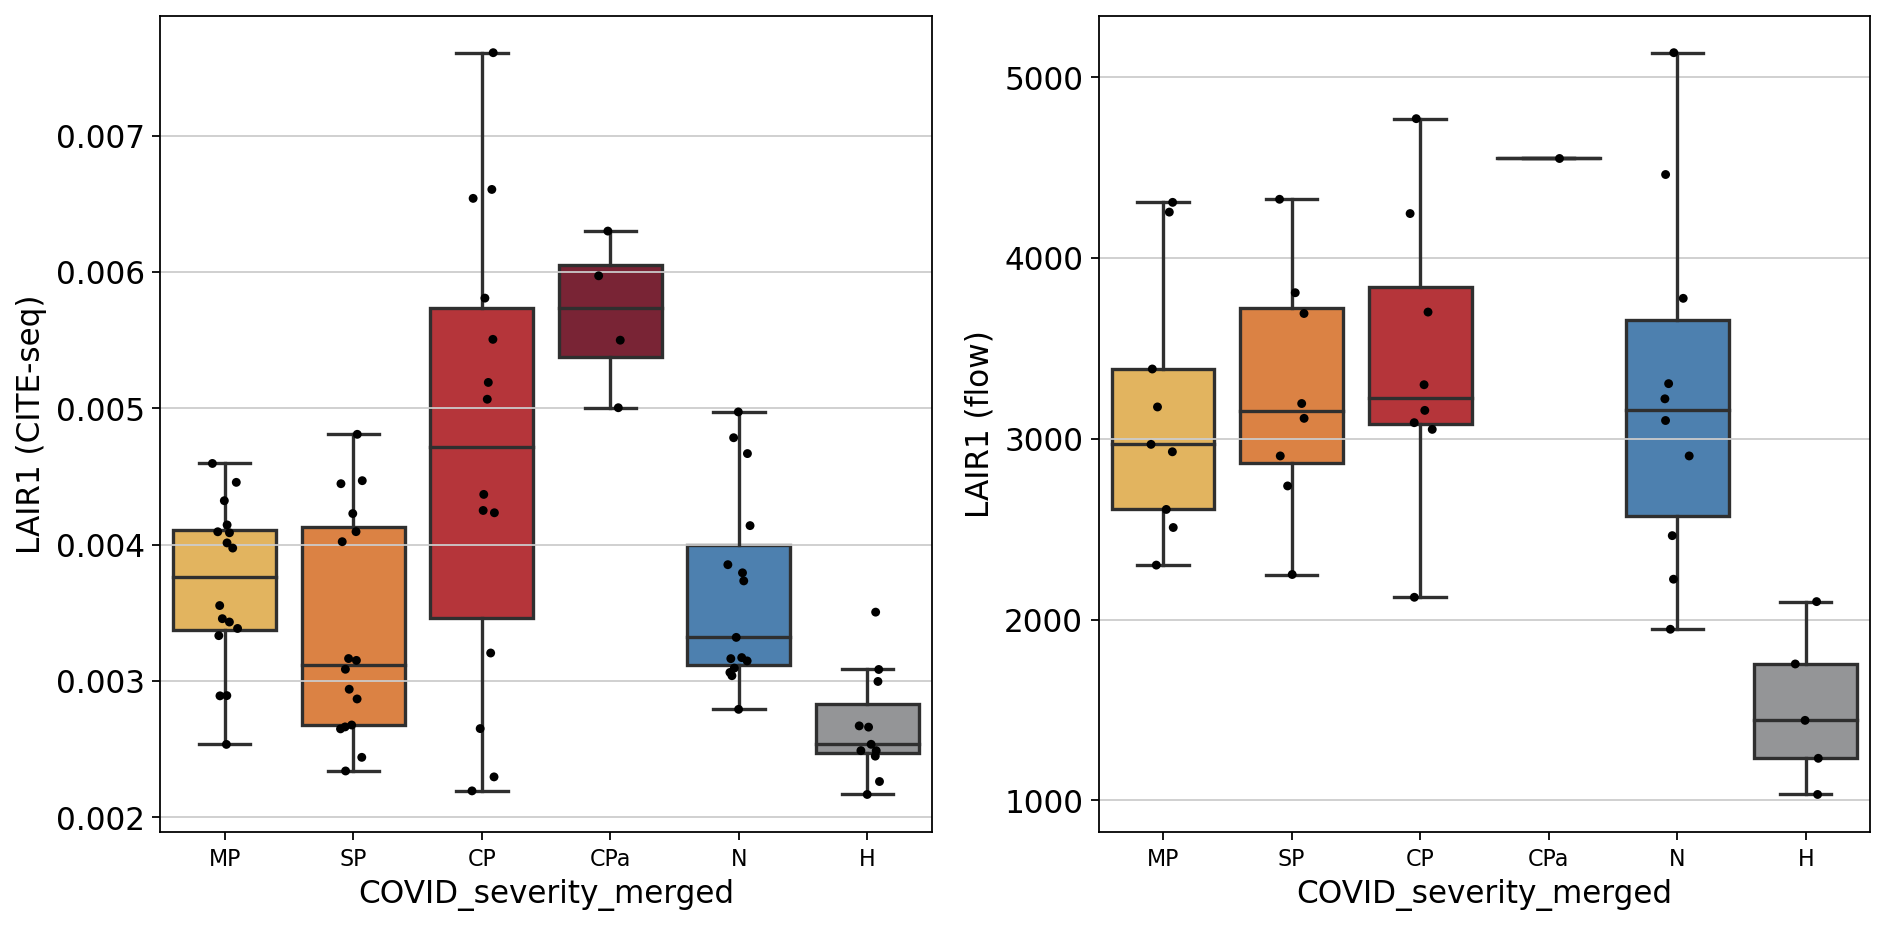

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for df, modality, ax in zip([df_p_cM, flow], 
                            ['CITE-seq', 'flow'],
                            np.ravel(ax)):
    sns.boxplot(data=df, x='COVID_severity_merged', y='LAIR1 (%s)' % modality, 
                order=order, ax=ax, palette=COVID_severity_merged_IFN_color_dict, fliersize=0);
    sns.stripplot(data=df, x="COVID_severity_merged", y='LAIR1 (%s)' % modality,
                  order=order, ax=ax, color='k', size=4);
    ax.set_xticklabels([''.join([i[0] for i in j.split('_')]) for j in order], rotation=0, size=10);
plt.tight_layout()

In [11]:
df_p_cM['donor'] = df_p_cM['donor'].str.replace('_C_', '').str.replace('-C-', '').str.lstrip('Rep') # make the names match what's in `flow`

In [12]:
df_joined = df_p_cM.drop(columns=['timepoint', 'ct1', 'ct_grp_LAIR1_p', 'ct_grp_SIGLEC1_p']).set_index('donor').join(flow.drop(columns='COVID_severity_merged').set_index('donor'), how='inner').dropna()

In [13]:
print(df_joined.shape[0])
print(flow.shape[0])
print(df_joined.shape[0]/flow.shape[0])

40
41
0.975609756097561


LinregressResult(slope=467534.9678524319, intercept=1394.2698483679078, rvalue=0.4308573014916294, pvalue=0.005512679405950726, stderr=158853.79301471694)


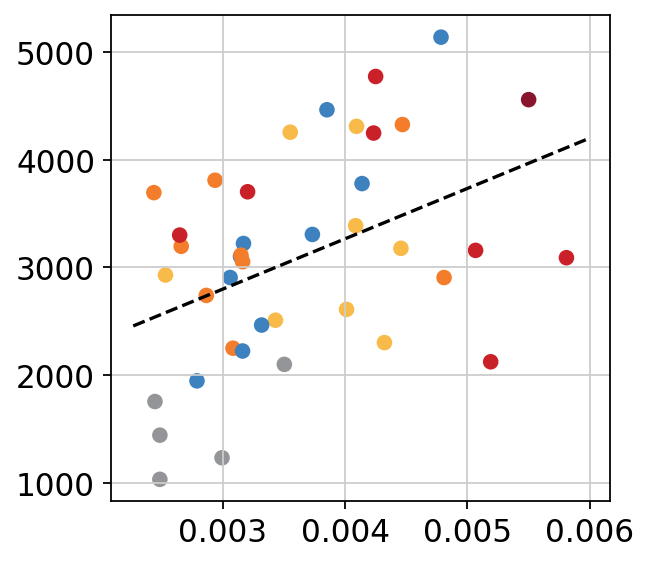

In [14]:
x = df_joined['LAIR1 (CITE-seq)'].values
y = df_joined['LAIR1 (flow)'].values
plt.scatter(x, y, 
            c=[COVID_severity_merged_IFN_color_dict[i] for i in df_joined['COVID_severity_merged'].values]);
res = scipy.stats.linregress(x, y)
xlim = plt.xlim()
plt.plot(xlim, (res.slope*xlim[0] + res.intercept, res.slope*xlim[1] + res.intercept), c='k', linestyle='--');
print(res)
plt.savefig(prefix_comet + 'figures/S4flow/flow_cite_LAIR1_corr.png', 
            bbox_inches='tight',
            dpi=300,
            pad_inches=0.1
           )
plt.show()